# Multipurpose Financial Data Processor (MFDP)
### Reid Clark, Updated: Feb 2024

| **Capabilities** |
| - |
| Valuation & Fundamental Analysis |
| Market Volatility Regression & Forecasting |
| Data Visualization |

# ***Demo***
---

### ***Run Raw Code***:

In [95]:
import ipywidgets as widgets
from ipywidgets import interact, Button, HBox
from IPython.display import display, HTML

def start_function():

    import requests
    from datetime import datetime, timedelta
    from decimal import Decimal
    import locale
    ## Format values as $USD
    locale.setlocale(locale.LC_ALL, 'en_US.UTF-8')

    import math
    from arch import arch_model
    from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
    import matplotlib.pyplot as plt

    import numpy as np
    import pandas as pd
    import pandas_datareader as web
    ## Set no limit in number of rows / columns displayed for large datasets of stocks:
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_rows', None)

    import yfinance as yf

    ## Currency formatter function
    def currency_formatter(value):
        return locale.currency(value, grouping=True)

    ticker = 'AAPL'

    period_input = '3y'

    # Part 1 - Fundamental Analysis #
    def main():
        def all():
            ## Sample Stock Input: Apple / AAPL
            stock1 = yf.Ticker(ticker)
            ## String slice & print
            print(f'Ticker Name: {ticker}')

            ## Set "S&P 500 Index" as the Industry Sector for all Beta Calculations
            market_index = yf.Ticker('^GSPC') # ...so S&P 500 only

            def grapher():
                ## Ask for period to chart, create .history dataframe
                user_period_input = str(input('Enter Time Period to Graph Here: '))
                df_stock1_info_grapher = pd.DataFrame(stock1.info(period=(user_period_input)))

                ## Gather 'x' recent history for stock...
                stock1_cvals_grapher = df_stock1_info_grapher['Close']
                np_stock1_cvals_grapher = np.array(stock1_cvals_grapher)

                ## Count i for elements in x axis
                elements_in_x_axis = len(df_stock1_info_grapher)
                x_axis = np.array(range(0,elements_in_x_axis))

                ## Plot graph
                plt.plot(x_axis, np_stock1_cvals_grapher, label='Close Values', color = "rebeccapurple")
                plt.title(f'{ticker} Closing Price, Period : {user_period_input}')
                plt.xlabel('Time (Days)')
                plt.ylabel('Price (Close Value)')
                plt.legend()
                plt.show()

            def main_body():
                def wacc_and_related():
                    def dcf_model():
                        def enterprise_valuator():
                            
                            ## Find enterprise value
                            ent_val = mkt_cap + total_debt - cash_and_ce
                            print(f'Enterprise Value: {currency_formatter(ent_val)}')

                            ## Calculate equity value of ticker (convert from ent_val)
                            equity_val = ent_val + bal_sheet['Cash Financial'] \
                                            + bal_sheet['Available For Sale Securities'] \
                                            - total_debt
                            
                            ## Print Implied Share Price
                            implied_share_price = equity_val / no_of_shares
                            print(f'Implied Share Price: {currency_formatter(implied_share_price)}')

                        ## Discounted Cash Flow Model Calculator
                        ## 1) Find FCF (Free Cash Flow)
                        fcf = cashflow_st['Free Cash Flow']

                        ## 2) Calculate Market Growth Rate. ('*2' as it is a ...
                        ## ... 6mo period. 'iloc' for more-accurate integer key (less output text desc.)
                        annual_g = (market_returns.iloc[-1] - market_returns.iloc[0])*2
                        
                        ## 3) Calculate Terminal Value using Perpetuity Growth Method
                        perp_growth_terminal_val = (fcf * (1 + annual_g)) / (wCoC - annual_g)

                        ## 4) Calculate Enterprise Value (ent_val)
                        enterprise_valuator()

                    ## Calculate WACC (wCoC)
                    wCoC = ((erp * beta) + rf) + cost_of_debt
                    print(f'Weighted Average Cost of Capital (WACC): {(round(wCoC,2))*100}%')

                    ## Call DCF discounted cash flow model calculator
                    dcf_model()
                
                ## Find bal sheet, income statement & cashflow stmt for ticker
                bal_sheet_date = '2023-09-30'
                bal_sheet = stock1.balance_sheet[bal_sheet_date]
                inc_st = stock1.income_stmt[bal_sheet_date]
                cashflow_st = stock1.cashflow[bal_sheet_date]
                df_cashflow_st = pd.DataFrame(cashflow_st)

                ## Find market cap & no. of shares for ticker
                mkt_cap = stock1.basic_info['marketCap']
                no_of_shares = bal_sheet['Ordinary Shares Number']
                
                ## Gather 6mo recent close value history for ticker,...
                ## ...arrange close values in pandas dataframe
                stock1_info = stock1.history
                df_stock1_info = pd.DataFrame(stock1_info(period='6mo'))
                stock1_cvals = df_stock1_info['Close']
                ## Gather 6mo recent close value history for market index...
                ## ...performance, ditto above
                ## arrange close values in pandas dataframe again
                market_data = market_index.history(period='6mo')
                df_market_data = pd.DataFrame(market_data)

                ## Calculate stock and market returns (pct change) for ticker
                stock1_returns = stock1_cvals.pct_change().dropna()
                market_returns = df_market_data['Close'].pct_change().dropna()

                ## Calculate covariance & variance of returns (ticker v market)
                covariance = np.cov(stock1_returns, market_returns)[0,1]
                variance_of_market = np.var(market_returns)

                ## Calculate beta of ticker
                beta = covariance / variance_of_market

                ## Designate Equity Risk Premium (erp) for USA (based on S&P), 2024 rate (4.6%)
                erp = 0.046
                ## Designate Rf (Risk-Free Rate). Assume time period 20y. (4.22%)
                ## Treasury Info Link: https://home.treasury.gov/resource-center/data-chart-center/interest-rates/TextView?type=daily_treasury_yield_curve&field_tdr_date_value=2023
                rf = 0.0422
                ## Designate Rm (Expected Market Return). Assume 8% (based on S&P Historical)
                rm = 0.08

                ## The below is possibly needed in the future
                ## Calculate Cost of Equity (Re)
                #cost_of_equity = rf + beta * (rm - rf)

                ## Find total assets, debt, and liabilities. calc future debt:
                total_assets = bal_sheet['Total Assets']
                total_debt = bal_sheet['Total Debt']
                total_liabilities = bal_sheet['Total Liabilities Net Minority Interest']
                future_debt = (bal_sheet['Long Term Debt']) \
                            + (bal_sheet['Other Non Current Liabilities']) \
                            + (bal_sheet['Tradeand Other Payables Non Current'])

                ## TOTAL EQUITY
                ## APIC Assume as $0 due to missing yfinance SoCI.
                cmn_stock = bal_sheet['Common Stock']
                cmn_stock_equity = bal_sheet['Common Stock Equity']
                treasury_stock = cmn_stock - cmn_stock_equity
                apic = bal_sheet['Capital Stock']
                retained_earnings = bal_sheet['Retained Earnings']
                ## Calc TE
                total_equity = cmn_stock + (apic*0) + retained_earnings + treasury_stock #+ oci 

                ## Calculate Market Value of Debt. Assume interest = rf above
                ## Also, assume 'n' (YTM) = 5, based on S&P typicals.
                ## Recall: CMVoD: pv = fv / (1+r)^n
                mkt_val_ofdebt = future_debt / (1+rf)**5
                ## Calculate Annual Interest Payment
                ## AIP = Total Debt x Interest Rate. Also assume interest = rf above
                ann_int_pmt = total_debt * rf
                ## Calculate Cost of Debt (Rd)
                cost_of_debt = ann_int_pmt / mkt_val_ofdebt

                ## Find weightages
                equity_weightage = (total_equity / mkt_cap) * 100
                debt_weightage = (total_debt / mkt_cap) * 100

                ## Find cash and cash equivalents
                cash_and_ce = bal_sheet['Cash And Cash Equivalents']

                ## Calculate debt ratio
                debt_ratio = total_debt / total_assets

                ## Call WACC_etc to begin technical analysis
                wacc_and_related()

            main_body()

        all()
    main()

    ## Restart program function
    def restart():
                print('Restart?')
                user_input = str(input('(Y/N):')).upper()
                if user_input == 'Y':
                    main()
                elif user_input == 'N':
                    print('Bonsoir mon Ami.')
                    exit()

    # Part 2 - GARCH #
    # Reset close vals to ensure data sufficiency
    yf_ticker = yf.Ticker(ticker)
    yf_hist = yf_ticker.history(period=(period_input))
    pd_yf_hist = pd.DataFrame(yf_hist)
    yf_cvals = pd_yf_hist['Close']
    np_yf_cvals = np.array([yf_cvals][0])

    # Unhash below to show PCAF plot
    #plot_pacf(np_yf_cvals**2)
    #plt.show()

    # Establish variables
    n = len(np_yf_cvals)
    omega = 0.35
    alpha_1 = 0.2
    #alpha_2 = 0.2
    beta_1 = 0.4
    #beta_2 = 0.4

    # Compress results for n to scale large data
    test_size = int(n*0.1)

    # Create loop to identify volatilities (vols). Append vols to list.
    vols_list = [1]
    for i in range(n-1):
        vol = np.sqrt(omega + alpha_1*np_yf_cvals[-1]**2 + beta_1*vols_list[-1]**2)
        vols_list.append(vol)

    train, test = np_yf_cvals[:-test_size], np_yf_cvals[-test_size:]
    model = arch_model(train, p=1, q=1)
    model_fit = model.fit(disp='off')
    #model_fit.summary()

    predictions = model_fit.forecast(horizon=test_size*2)
    #plt.figure(figsize=(10,4))
    #true, = plt.plot(vols_list[-test_size:])
    #preds, = plt.plot(np.sqrt(predictions.variance.values[-1,:]))

    rolling_predictions = []
    for i in range(test_size):
        train = np_yf_cvals[:-(test_size-i)]
        model = arch_model(train, p=1, q=1)
        model_fit = model.fit(disp='off')
        pred = model_fit.forecast(horizon=1)
        rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]) - 10)

    #plt.figure(figsize=(10,4))
    #true, = plt.plot(np_yf_cvals[:-test_size-i])
    #preds, = plt.plot(rolling_predictions)

    plt.figure(figsize=(10,4))
    true, = plt.plot((np_yf_cvals[:-test_size-i])[:len(rolling_predictions)])
    preds, = plt.plot(rolling_predictions)
    plt.legend(['True Volatility', 'Predicted Volatility'], fontsize=16)


button = widgets.Button(description='Run Demo - AAPL Apple Inc.')

def on_button_click(b):
    start_function()

button.on_click(on_button_click)

button.style.button_color = 'blue'
button.style.text_color = 'white'

button_container = widgets.HBox([button], layout=widgets.Layout(justify_content='center'))

display(button_container)

## Part 1 - Valuation & Fundamental Analysis
---

#### 1: Import Libraries

In [96]:
import requests
import ipywidgets as widgets
from ipywidgets import interact, Button
from IPython.display import display, HTML
from datetime import datetime, timedelta
from decimal import Decimal
import locale
## Format values as $USD
locale.setlocale(locale.LC_ALL, 'en_US.UTF-8')

import math
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import pandas_datareader as web
## Set no limit in number of rows / columns displayed for large datasets of stocks:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import yfinance as yf

#### 2: Format Currency

In [97]:
## Currency formatter function
def currency_formatter(value):
    return locale.currency(value, grouping=True)

#### 3: Main Ticker Valuation & Fundamental Analysis

In [98]:
ticker = 'AAPL'

In [99]:
## Main calc function
def main():
    def all():
        ## Sample Stock Input: Apple / AAPL
        stock1 = yf.Ticker(ticker)
        ## String slice & print
        print(f'Ticker Name: {ticker}')

        ## Set "S&P 500 Index" as the Industry Sector for all Beta Calculations
        market_index = yf.Ticker('^GSPC') # ...so S&P 500 only

        def grapher():
            ## Ask for period to chart, create .history dataframe
            user_period_input = str(input('Enter Time Period to Graph Here: '))
            df_stock1_info_grapher = pd.DataFrame(stock1.info(period=(user_period_input)))

            ## Gather 'x' recent history for stock...
            stock1_cvals_grapher = df_stock1_info_grapher['Close']
            np_stock1_cvals_grapher = np.array(stock1_cvals_grapher)

            ## Count i for elements in x axis
            elements_in_x_axis = len(df_stock1_info_grapher)
            x_axis = np.array(range(0,elements_in_x_axis))

            ## Plot graph
            plt.plot(x_axis, np_stock1_cvals_grapher, label='Close Values', color = "rebeccapurple")
            plt.title(f'{ticker} Closing Price, Period : {user_period_input}')
            plt.xlabel('Time (Days)')
            plt.ylabel('Price (Close Value)')
            plt.legend()
            plt.show()

        def main_body():
            def wacc_and_related():
                def dcf_model():
                    def enterprise_valuator():
                        
                        ## Find enterprise value
                        ent_val = mkt_cap + total_debt - cash_and_ce
                        print(f'Enterprise Value: {currency_formatter(ent_val)}')

                        ## Calculate equity value of ticker (convert from ent_val)
                        equity_val = ent_val + bal_sheet['Cash Financial'] \
                                        + bal_sheet['Available For Sale Securities'] \
                                        - total_debt
                        
                        ## Print Implied Share Price
                        implied_share_price = equity_val / no_of_shares
                        print(f'Implied Share Price: {currency_formatter(implied_share_price)}')

                    ## Discounted Cash Flow Model Calculator
                    ## 1) Find FCF (Free Cash Flow)
                    fcf = cashflow_st['Free Cash Flow']

                    ## 2) Calculate Market Growth Rate. ('*2' as it is a ...
                    ## ... 6mo period. 'iloc' for more-accurate integer key (less output text desc.)
                    annual_g = (market_returns.iloc[-1] - market_returns.iloc[0])*2
                    
                    ## 3) Calculate Terminal Value using Perpetuity Growth Method
                    perp_growth_terminal_val = (fcf * (1 + annual_g)) / (wCoC - annual_g)

                    ## 4) Calculate Enterprise Value (ent_val)
                    enterprise_valuator()

                ## Calculate WACC (wCoC)
                wCoC = ((erp * beta) + rf) + cost_of_debt
                print(f'Weighted Average Cost of Capital (WACC): {(round(wCoC,2))*100}%')

                ## Call DCF discounted cash flow model calculator
                dcf_model()
            
            ## Find bal sheet, income statement & cashflow stmt for ticker
            bal_sheet_date = '2023-09-30'
            bal_sheet = stock1.balance_sheet[bal_sheet_date]
            inc_st = stock1.income_stmt[bal_sheet_date]
            cashflow_st = stock1.cashflow[bal_sheet_date]
            df_cashflow_st = pd.DataFrame(cashflow_st)

            ## Find market cap & no. of shares for ticker
            mkt_cap = stock1.basic_info['marketCap']
            no_of_shares = bal_sheet['Ordinary Shares Number']
            
            ## Gather 6mo recent close value history for ticker,...
            ## ...arrange close values in pandas dataframe
            stock1_info = stock1.history
            df_stock1_info = pd.DataFrame(stock1_info(period='6mo'))
            stock1_cvals = df_stock1_info['Close']
            ## Gather 6mo recent close value history for market index...
            ## ...performance, ditto above
            ## arrange close values in pandas dataframe again
            market_data = market_index.history(period='6mo')
            df_market_data = pd.DataFrame(market_data)

            ## Calculate stock and market returns (pct change) for ticker
            stock1_returns = stock1_cvals.pct_change().dropna()
            market_returns = df_market_data['Close'].pct_change().dropna()

            ## Calculate covariance & variance of returns (ticker v market)
            covariance = np.cov(stock1_returns, market_returns)[0,1]
            variance_of_market = np.var(market_returns)

            ## Calculate beta of ticker
            beta = covariance / variance_of_market

            ## Designate Equity Risk Premium (erp) for USA (based on S&P), 2024 rate (4.6%)
            erp = 0.046
            ## Designate Rf (Risk-Free Rate). Assume time period 20y. (4.22%)
            ## Treasury Info Link: https://home.treasury.gov/resource-center/data-chart-center/interest-rates/TextView?type=daily_treasury_yield_curve&field_tdr_date_value=2023
            rf = 0.0422
            ## Designate Rm (Expected Market Return). Assume 8% (based on S&P Historical)
            rm = 0.08

            ## The below is possibly needed in the future
            ## Calculate Cost of Equity (Re)
            #cost_of_equity = rf + beta * (rm - rf)

            ## Find total assets, debt, and liabilities. calc future debt:
            total_assets = bal_sheet['Total Assets']
            total_debt = bal_sheet['Total Debt']
            total_liabilities = bal_sheet['Total Liabilities Net Minority Interest']
            future_debt = (bal_sheet['Long Term Debt']) \
                        + (bal_sheet['Other Non Current Liabilities']) \
                        + (bal_sheet['Tradeand Other Payables Non Current'])

            ## TOTAL EQUITY
            ## APIC Assume as $0 due to missing yfinance SoCI.
            cmn_stock = bal_sheet['Common Stock']
            cmn_stock_equity = bal_sheet['Common Stock Equity']
            treasury_stock = cmn_stock - cmn_stock_equity
            apic = bal_sheet['Capital Stock']
            retained_earnings = bal_sheet['Retained Earnings']
            ## Calc TE
            total_equity = cmn_stock + (apic*0) + retained_earnings + treasury_stock #+ oci 

            ## Calculate Market Value of Debt. Assume interest = rf above
            ## Also, assume 'n' (YTM) = 5, based on S&P typicals.
            ## Recall: CMVoD: pv = fv / (1+r)^n
            mkt_val_ofdebt = future_debt / (1+rf)**5
            ## Calculate Annual Interest Payment
            ## AIP = Total Debt x Interest Rate. Also assume interest = rf above
            ann_int_pmt = total_debt * rf
            ## Calculate Cost of Debt (Rd)
            cost_of_debt = ann_int_pmt / mkt_val_ofdebt

            ## Find weightages
            equity_weightage = (total_equity / mkt_cap) * 100
            debt_weightage = (total_debt / mkt_cap) * 100

            ## Find cash and cash equivalents
            cash_and_ce = bal_sheet['Cash And Cash Equivalents']

            ## Calculate debt ratio
            debt_ratio = total_debt / total_assets

            ## Call WACC_etc to begin technical analysis
            wacc_and_related()

        main_body()

    all()
main()

## Restart program function
def restart():
            print('Restart?')
            user_input = str(input('(Y/N):')).upper()
            if user_input == 'Y':
                main()
            elif user_input == 'N':
                print('Bonsoir mon Ami.')
                exit()


Ticker Name: AAPL
Weighted Average Cost of Capital (WACC): 13.0%
Enterprise Value: $2,997,325,818,601.88
Implied Share Price: $193.90


## Part 2 - GARCH(a,b) Regression Learning Model
---

#### 4: Plot PCAF (Partial Autocorrelation) of Historical Data to Identify GARCH Parameters.

In [100]:
period_input = '3y'

In [101]:
# Reset close vals to ensure data sufficiency
yf_ticker = yf.Ticker(ticker)
yf_hist = yf_ticker.history(period=(period_input))
pd_yf_hist = pd.DataFrame(yf_hist)
yf_cvals = pd_yf_hist['Close']
np_yf_cvals = np.array([yf_cvals][0])

# Unhash below to show PCAF plot
#plot_pacf(np_yf_cvals**2)
#plt.show()

#### 5: Calculate Per-Period Volatility (% Change) based on Historical Price Data.

In [102]:
# Establish variables
n = len(np_yf_cvals)
omega = 0.35
alpha_1 = 0.2
#alpha_2 = 0.2
beta_1 = 0.4
#beta_2 = 0.4

# Compress results for n to scale large data
test_size = int(n*0.1)

# Create loop to identify volatilities (vols). Append vols to list.
vols_list = [1]
for i in range(n-1):
    vol = np.sqrt(omega + alpha_1*np_yf_cvals[-1]**2 + beta_1*vols_list[-1]**2)
    vols_list.append(vol)

#### 6: Train and Test GARCH(a,b) Model. Print Results Summary.

In [103]:
train, test = np_yf_cvals[:-test_size], np_yf_cvals[-test_size:]
model = arch_model(train, p=1, q=1)
model_fit = model.fit(disp='off')
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -2642.50
Distribution:                  Normal   AIC:                           5293.01
Method:            Maximum Likelihood   BIC:                           5311.09
                                        No. Observations:                  680
Date:                Sun, Feb 11 2024   Df Residuals:                      679
Time:                        14:45:53   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu           146.8842      0.443    331.926      0.000 [1.460e+02,1.478e+02]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          5.0730      1.143      4.438  9.073e-06 [  2.833,  7.313]
alpha[1]       1.0000  6.823e-02     14.657  1.220e-48 [  0.866,  1.134]
beta[1]        0.0000  5.975e-02      0.000      1.000 [ -0.117,  0.117]
========================================================================

Covariance estimator: robust
"""

#### 7: Calculate **Simple** & **Rolling Volatility** Predictions based on Model

In [104]:
predictions = model_fit.forecast(horizon=test_size*2)
#plt.figure(figsize=(10,4))
#true, = plt.plot(vols_list[-test_size:])
#preds, = plt.plot(np.sqrt(predictions.variance.values[-1,:]))

rolling_predictions = []
for i in range(test_size):
    train = np_yf_cvals[:-(test_size-i)]
    model = arch_model(train, p=1, q=1)
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=1)
    rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]) - 10)

#plt.figure(figsize=(10,4))
#true, = plt.plot(np_yf_cvals[:-test_size-i])
#preds, = plt.plot(rolling_predictions)

#### 9: Plot Predictions

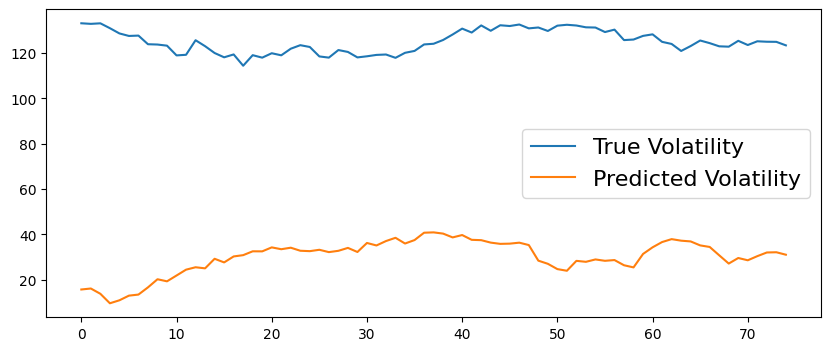

In [105]:
plt.figure(figsize=(10,4))
true, = plt.plot((np_yf_cvals[:-test_size-i])[:len(rolling_predictions)])
preds, = plt.plot(rolling_predictions)
plt.legend(['True Volatility', 'Predicted Volatility'], fontsize=16)